# 緻密なニューラルネットワークの学習

手書きの数字の認識は、分類問題です。ここでは、画像分類のための最も単純なアプローチである、完全結合型のニューラルネットワーク（パーセプトロンとも呼ばれる）から始めます。前のユニットで説明したすべてのデータを読み込むために、`pytorchcv`ヘルパーを使います。

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2021-08-16 11:27:26--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 6371 (6.2K) [text/plain]
`pytorchcv.py' に保存中

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s 時間 0s       

2021-08-16 11:27:27 (32.3 MB/s) - `pytorchcv.py' へ保存完了 [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

## 完全結合型の密なニューラルネットワーク

PyTorchの基本的な**ニューラルネットワーク**は、いくつかの**レイヤー**で構成されています。最も単純なネットワークは、784の入力(入力画像の各ピクセルに1つの入力)と10の出力(各クラスに1つの出力)を持つ、**Linear**層と呼ばれる完全連結の層を1つだけ含みます。

![画像をピクセル単位でレイヤーに分割して表示したグラフ](./images/dense-onelayer-network.png)

先に述べたように、数字の画像の次元は $1\times28\times28$ です。完全連結層の入力次元は784なので、テンソルの形を $1\times28\times28$ から $784$ に変更するためには、**Flatten**という層をネットワークに挿入する必要があります。

ネットワークの $n$ 番目の出力は、入力された数字が $n$ に等しい確率を返すようにしたい。完全連結層の出力は0と1の間になるように正規化されていないので、確率として考えることはできません。これを確率に変えるためには、**Softmax**という別の層を適用する必要があります。

PyTorchでは、**LogSoftmax**関数を使うのが簡単で、出力確率の対数も計算できます。出力ベクトルを実際の確率に変えるためには、出力の **torch.exp** を取る必要があります。

したがって、このネットワークのアーキテクチャは、次のような層の並びで表されます。

![ネットワークのアーキテクチャを一連のレイヤーに分割したイメージ図](./images/onelayer-network-layers.png)

PyTorchでは、`Sequential`構文を用いて、以下のように定義できます。

In [3]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),  # 784 inputs, 10 outputs
    nn.LogSoftmax())

## ネットワークのトレーニング

このように定義されたネットワークは、任意の数字を入力とし、確率のベクトルを出力とします。このネットワークがどのように機能するか、データセットから数字を与えて見てみましょう。

In [4]:
print('Digit to be predicted: ', data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted:  5


/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1221, 0.0845, 0.1005, 0.1090, 0.0950, 0.0898, 0.1188, 0.0738, 0.1199,
         0.0866]], grad_fn=<ExpBackward>)

ご覧のように、ネットワークは各数字に対して似たような確率を予測しています。これは、ネットワークが数字を認識する方法を学習していないためです。私たちのデータセットで訓練するために、訓練データを与える必要があります。

モデルを学習するためには、データセットの**バッチ**を一定の大きさ（64個とします）で作成する必要があります。PyTorchには**DataLoader**というオブジェクトがあり、自動的にデータのバッチを作成してくれます。

トレーニングプロセスのステップは以下の通りです。

1. 入力データセットから、入力データ（特徴量）と期待される結果（ラベル）からなるミニバッチを取得する。
2. このミニバッチに対する予測結果を計算する。
3. 予測結果と予想結果の差を、**損失関数**と呼ばれる特殊な関数を用いて算出する。
4. モデルの重み（パラメータ）に対する損失関数の勾配を計算し，ネットワークの性能を最適化するために重みを調整します。調整量は**learning rate**というパラメータで制御され、最適化アルゴリズムの詳細は**optimizer**オブジェクトで定義されています。
5. これらの手順をデータセット全体が処理されるまで繰り返す。データセットを完全に処理することを **1エポック** と呼ぶ。

以下に，1エポックの学習を行う関数を示します。

In [5]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)  # cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count


train_epoch(net, train_loader)

(0.005936351013183593, 0.8927833333333334)

この関数はかなり一般的なものなので、後で他の例でも使用することができます。この関数は，以下のパラメータを受け取ります．

* **ニューラルネットワーク**
* **DataLoader**：学習するデータを定義します。
* **損失関数**, これは期待される結果とネットワークによって生成された結果との差を測定する関数です。ほとんどの分類タスクでは、`NLLLoss`が使用されるので、これをデフォルトにします。
* **Optimizer**, これは *最適化アルゴリズム* を定義したものです。最も伝統的なアルゴリズムは *stochastic gradient descent* ですが、ここではデフォルトで**Adam**と呼ばれるより高度なバージョンを使用します。
* **Learning rate** ネットワークが学習する速度を定義します。学習中は、同じデータを何度も表示し、その度に重みを調整します。学習率が高すぎると新しい値が古い値からの知識を上書きしてしまい、ネットワークの性能が低下してしまいます。また、学習率が低すぎると、学習が非常に遅くなります。

学習時に行うことは以下の通りです。

* ネットワークを学習モードに切り替える（`net.train()`）。
* データセットのすべてのバッチを確認し、各バッチごとに以下の処理を行います。
  * このバッチに対するネットワークの予測値を計算する (`out`)
  * 予測値と期待値の不一致である「損失」を計算する。
  * ネットワークの重みを調整して、損失の最小化を試みる（`optimizer.step()`）。
  * 正しく予測されたケースの数を計算します（**accuracy**）。

この関数はデータ項目ごとの平均損失と、学習精度（正しく推測されたケースの割合）を計算して返します。学習中にこの損失を観察することで、ネットワークが改善され、提供されたデータから学習しているかどうかを知ることができます。

また、テストデータセットでの精度をコントロールすることも重要です（**検証精度**とも呼ばれます）。多くのパラメータを持つ優れたニューラルネットワークは、どんな訓練データセットでもそこそこの精度で予測できますが、他のデータへの汎化がうまくいかないことがあります。そのため、多くの場合、データの一部を確保しておき、そのデータに対してモデルがどの程度の性能を発揮するかを定期的にチェックします。ここでは，テストデータセットでネットワークを評価する関数を紹介します。

In [6]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            out = net(features)
            loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
            count += len(labels)
    return loss.item() / count, acc.item() / count


validate(net, test_loader)

(0.005875361251831055, 0.893)

数回のエポックでモデルをトレーニングし、トレーニングと検証の精度を観察します。もし、トレーニングの精度が上がり、バリデーションの精度が下がるようであれば、それは**オーバーフィッティング**の兆候です。つまり、あなたのデータセットではうまくいっても、新しいデータではうまくいかないということです。

以下は、トレーニングと検証の両方を行うために使用できるトレーニング関数です。各エポックのトレーニングと検証の精度を表示し、損失と精度をグラフにプロットするために使用できる履歴も返します。

In [7]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res


# Re-initialize the network to start from scratch
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),  # 784 inputs, 10 outputs
    nn.LogSoftmax())

hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.898, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


この関数は、各エポックのトレーニングデータと検証データの精度をメッセージに記録します。また、このデータを辞書(**history**)として返します。このデータを可視化することで、モデルのトレーニングをより理解することができます。

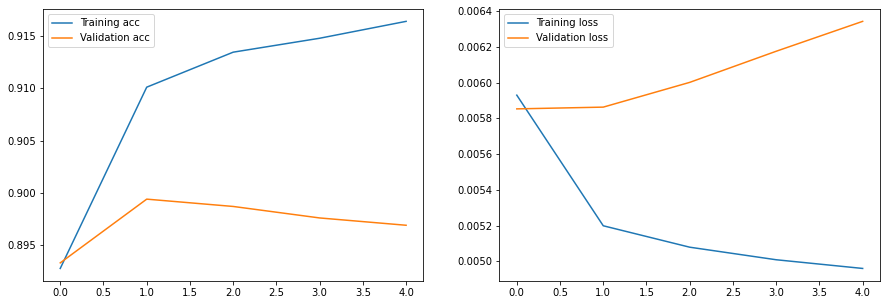

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

左側の図では、`training accuracy`が上昇し（これはネットワークが学習データをより良く分類するように学習していることに対応する）、`validation accuracy`が低下し始めています。右側の図は`training loss`と`validation loss`を示しており、`training loss`が減少し（性能が向上していることを意味する）、`validation loss`が増加している（性能が低下していることを意味する）ことがわかります。これらのグラフは、モデルが **オーバーフィット** していることを示しています。

## ネットワークウエイトの可視化

では、ニューラルネットワークの重みを視覚化して、その様子を見てみましょう。ネットワークが1つの層よりも複雑な場合、結果をこのように可視化するのは難しいかもしれません。しかし、今回のケース（数字の分類）では、最初の画像に重み行列を掛け合わせることで、ネットワークの重みをちょっとしたロジックを加えて視覚化することができます。

784x10の次元を持つ`weight_tensor`を作成してみましょう。このテンソルは、`net.parameters()`メソッドを呼び出すことで得られます。この例では、数字が0であるかどうかを確認したい場合、入力された数字に `weight_tensor[0]` を掛けて、その結果をソフトマックス正規化に通して答えを得ます。この結果、重みテンソルの要素は、分類する数字の平均的な形にある程度似てきます。

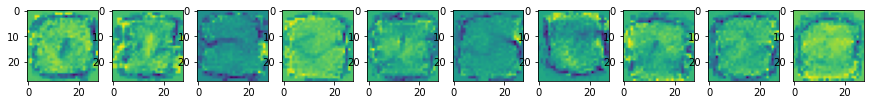

In [9]:
weight_tensor = next(net.parameters())
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for i, x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28, 28).detach())

## 覚えておくべき重要点

PyTorchでのニューラルネットワークの学習は、トレーニングループを使ってプログラムすることができます。複雑なプロセスに見えるかもしれませんが、実際には一度書いてしまえば、後からこのトレーニングコードを変更することなく再利用することができます。

単層の密なニューラルネットワークは比較的良い性能を示すことがわかりますが、私たちは絶対に91%以上の精度を得たいと思っています。次のユニットでは、マルチレベル・パーセプトロンを使ってみましょう。